In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import numpy as np
from scipy.special import logit
import math
from tqdm import tqdm

In [2]:
# this is all of the gLEE variables in the vertex_tree that we want to look at
gLEE_vars = [
    "run_number", 
    "subrun_number", 
    "event_number",
    "reco_shower_energy_plane0",
    "reco_shower_energy_plane1",
    "reco_shower_energy_plane2",
    "reco_vertex_x",
    "reco_vertex_y",
    "reco_vertex_z",
]

# this is all of the wire-cell variables that we want to look at
WC_vars = [
    "data_or_pred",
    "run", 
    "subrun", 
    "event", 
    "category",
    "WC_file",
    "match_isFC",
    "kine_reco_Enu", 
    "reco_showerKE", 
    "nc_delta_score",
    "WC_reco_num_protons",
    "WC_reco_num_other_tracks",
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
]

In [3]:
merged_gLEE_WC_comparison_df = pd.read_pickle("merged_gLEE_WC_comparison_df_v3.pkl")
#merged_gLEE_WC_comparison_df = pd.read_pickle("merged_gLEE_WC_comparison_df.pkl")

In [4]:
# from Mark slack message 06/21/21
merged_gLEE_WC_comparison_df["reco_shower_energy_plane2_corrected"] = merged_gLEE_WC_comparison_df["reco_shower_energy_plane2"].to_numpy() * 1.21 + 9.88

In [5]:
#merged_gLEE_WC_comparison_df.query("gLEE_selection=='1g0p'")

In [6]:
print("totals (includes all MC, ext, and data that we might compare):\n")
print("num in combined gLEE selection and WC files:", merged_gLEE_WC_comparison_df.shape[0])
print("num in WC files:", merged_gLEE_WC_comparison_df.query(
    "WC_reco_num_protons==WC_reco_num_protons").shape[0])
print("num in gLEE selection:", merged_gLEE_WC_comparison_df.query(
    "reco_shower_energy_plane2==reco_shower_energy_plane2").shape[0])
print("num in both gLEE selection and in WC files:", merged_gLEE_WC_comparison_df.query(
    "reco_shower_energy_plane0==reco_shower_energy_plane0 and WC_reco_num_protons==WC_reco_num_protons").shape[0])
print("num in both gLEE and WC selections:", merged_gLEE_WC_comparison_df.query(
    "kine_reco_Enu >= 0 and match_isFC == 1 and nc_delta_score > 3 and reco_shower_energy_plane2==reco_shower_energy_plane2").shape[0])

print("\nnum in both gLEE 1g1p and WC Np selections:", merged_gLEE_WC_comparison_df.query(
    "kine_reco_Enu >= 0 and match_isFC == 1 and nc_delta_score > 3 and WC_reco_num_protons >= 0 and gLEE_selection=='1g1p'").shape[0])
print("num in both gLEE 1g0p and WC 0p selections:", merged_gLEE_WC_comparison_df.query(
    "kine_reco_Enu >= 0 and match_isFC == 1 and nc_delta_score > 3 and WC_reco_num_protons == 0 and gLEE_selection=='1g0p'").shape[0])

print("\nnum in both gLEE 1g1p and WC 1p0pi selections:", merged_gLEE_WC_comparison_df.query(
    "kine_reco_Enu >= 0 and match_isFC == 1 and nc_delta_score > 3 and WC_reco_num_protons == 1 and WC_reco_num_other_tracks == 0 and gLEE_selection=='1g1p'").shape[0])
print("num in both gLEE 1g0p and WC 0p0pi selections:", merged_gLEE_WC_comparison_df.query(
    "kine_reco_Enu >= 0 and match_isFC == 1 and nc_delta_score > 3 and WC_reco_num_protons == 0 and WC_reco_num_other_tracks == 0 and gLEE_selection=='1g0p'").shape[0])

totals (includes all MC, ext, and data that we might compare):

num in combined gLEE selection and WC files: 8171675
num in WC files: 8169393
num in gLEE selection: 5554
num in both gLEE selection and in WC files: 3272
num in both gLEE and WC selections: 922

num in both gLEE 1g1p and WC Np selections: 226
num in both gLEE 1g0p and WC 0p selections: 617

num in both gLEE 1g1p and WC 1p0pi selections: 188
num in both gLEE 1g0p and WC 0p0pi selections: 587


In [7]:
gLEE_categories = ["NCDelta", "NCPi0Coh", "NCPi0NotCoh", "CC1Pi0", "BNBOther", "Nue", "OTPC", "Dirt", "BNBext"]

gLEE_queries = [
    f"gLEE_file == '{gLEE_categories[0]}'",
    f"gLEE_file == '{gLEE_categories[1]}'",
    f"gLEE_file == '{gLEE_categories[2]}'",
    f"gLEE_file == '{gLEE_categories[3]}'",
    f"gLEE_file == '{gLEE_categories[4]}'",
    f"gLEE_file == '{gLEE_categories[5]}'",
    f"gLEE_file == '{gLEE_categories[6]}'",
    f"gLEE_file == '{gLEE_categories[7]}'",
    f"gLEE_file == '{gLEE_categories[8]}'",
]

gLEE_colors = [
    "yellow",
    "salmon",
    "tomato",
    "royalblue",
    "skyblue",
    "orchid",
    "cyan",
    "brown",
    "limegreen",
]

In [8]:
wc_categories = ["NC Delta Radiative", "NC 1 Pi0", "numuCC 1 Pi0", "nueCC", "numuCC other", "NC other", "outFV", "badmatch/cosmic", "dirt", "ext", 
              "not found in WC files"]

wc_queries = [
    f"category == '{wc_categories[0]}'",
    f"category == '{wc_categories[1]}'",
    f"category == '{wc_categories[2]}'",
    f"category == '{wc_categories[3]}'",
    f"category == '{wc_categories[4]}'",
    f"category == '{wc_categories[5]}'",
    f"category == '{wc_categories[6]}'",
    f"category == '{wc_categories[7]}'",
    f"category == '{wc_categories[8]}'",
    f"category == '{wc_categories[9]}'",
    "not (WC_reco_num_protons==WC_reco_num_protons)"
]

wc_colors = [
    "yellow",
    "tomato",
    "royalblue",
    "orchid",
    "orange",
    "pink",
    "cyan",
    "turquoise",
    "brown",
    "limegreen",
    "dimgrey"
]

In [9]:
nc_delta_scores = []
energies = merged_gLEE_WC_comparison_df["kine_reco_Enu"].to_numpy()
nc_delta_initial_scores = merged_gLEE_WC_comparison_df["nc_delta_score"].to_numpy()
for i in tqdm(range(merged_gLEE_WC_comparison_df.shape[0])):
    energy = energies[i]
    nc_delta_score = nc_delta_initial_scores[i]
    
    if energy < 0:# or np.isnan(energy):
        nc_delta_scores.append(-20.)
    else:
        nc_delta_scores.append(nc_delta_score)
merged_gLEE_WC_comparison_df["nc_delta_score"] = nc_delta_scores

100%|██████████| 8171675/8171675 [00:20<00:00, 396157.77it/s]


In [10]:
for x_variable in ["reco_shower_energy_plane2_corrected", "nc_delta_score"]:

    for breakdown_num in [0, 1]:

        categories = [gLEE_categories, wc_categories][breakdown_num]
        queries = [gLEE_queries, wc_queries][breakdown_num]
        colors = [gLEE_colors, wc_colors][breakdown_num]

        for sel in ["1g1p", "1g0p"]:

            gLEE_sel_selected_df = merged_gLEE_WC_comparison_df.query(f"gLEE_selection == '{sel}'")

            selected_e_categories = []
            selected_w_categories = []

            for q in queries:
                selected_e_categories.append(gLEE_sel_selected_df.query(f"{q}")[x_variable].to_numpy())
                selected_w_categories.append(gLEE_sel_selected_df.query(f"{q}")["simple_pot_weight"].to_numpy())
            
            if x_variable == "reco_shower_energy_plane2_corrected":
                bin_edges = [i*100. for i in range(9)]            
            elif x_variable == "nc_delta_score":
                bin_edges = [2. * i - 24. + 2.61 for i in range(19)]
            
            bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2. for i in range(len(bin_edges) - 1)]
            num_bins = len(bin_edges) - 1
            
            hist_, bin_edges_ = np.histogram(gLEE_sel_selected_df.query("data_or_pred == 'data'")[x_variable].to_numpy(), bins=1, range=(-1e6, 1e6))
            
            data_total = hist_[0]
            
            hist_, bin_edges_ = np.histogram(gLEE_sel_selected_df.query("data_or_pred == 'data'")[x_variable].to_numpy(), bins=bin_edges)

            data_points = hist_
            data_xerr = (bin_edges[1] - bin_edges[0]) / 2.
            data_yerr = [np.sqrt(x) for x in data_points]

            plt.clf()
            plt.figure(dpi=200, figsize=(10,7))

            total_counts = []
            for i in range(len(selected_e_categories)):
                hist_, bin_edges_ = np.histogram(selected_e_categories[i], bins=1, range=(-1e6, 1e6), weights=selected_w_categories[i])
                total_counts.append(hist_[0])
            legend_strings = [categories[i] + ", " + str(np.round(total_counts[i], 3)) + " (" + str(len(selected_e_categories[i])) + ")" for i in range(len(categories))]

            plt.plot([], [], " ", label="total prediction: " + str(np.round(np.sum(total_counts), 4)))

            n_, bins_, patches = plt.hist(selected_e_categories, bins=bin_edges, weights=selected_w_categories, color=colors, label=legend_strings, stacked=True)
            
            total_pred_by_bin = n_[-1]
            
            plt.errorbar(bin_centers, data_points, yerr=data_yerr, xerr=data_xerr, fmt="none", capsize=5, c="black", zorder=10)
            plt.scatter(bin_centers, data_points, label=f"0.41E20 run1 BNB open data, {data_total}", color="black", zorder=10)

            handles, labels = plt.gca().get_legend_handles_labels()
            order = [i + 1 for i in range(len(queries))] + [0, len(queries) + 1]
            #order = [1,2,3,4,5,6,7,8,9,10,11,0,12]
            L = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
            L.set_zorder(20)
            
            if x_variable == "reco_shower_energy_plane2_corrected":
                plt.xlabel("gLEE corrected shower energy (1.21 * reco_shower_energy_plane2 + 9.88) (MeV)")
            elif x_variable == "nc_delta_score":
                plt.xlabel("WC NC Delta Score")
                plt.axvline(2.61, c="black", linestyle="dashed")
                
            plt.ylabel("weighted count")
            plt.title(f"gLEE {sel} selection using breakdown categories from {['gLEE', 'WC'][breakdown_num]} files")
            
            plt.ylim(0, 1.2 * np.max(np.concatenate((total_pred_by_bin, data_points + data_yerr))))
            
            plt.savefig(f"gLEE_comparison_plots/gLEE_{sel}_{x_variable}_{['gLEE', 'WC'][breakdown_num]}_breakdown.png")
            #plt.show()
            plt.clf()

pass

/Users/lmh227/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/lmh227/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/Users/lmh227/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/lmh227/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


<Figure size 432x288 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

3001
3001


<Figure size 432x288 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

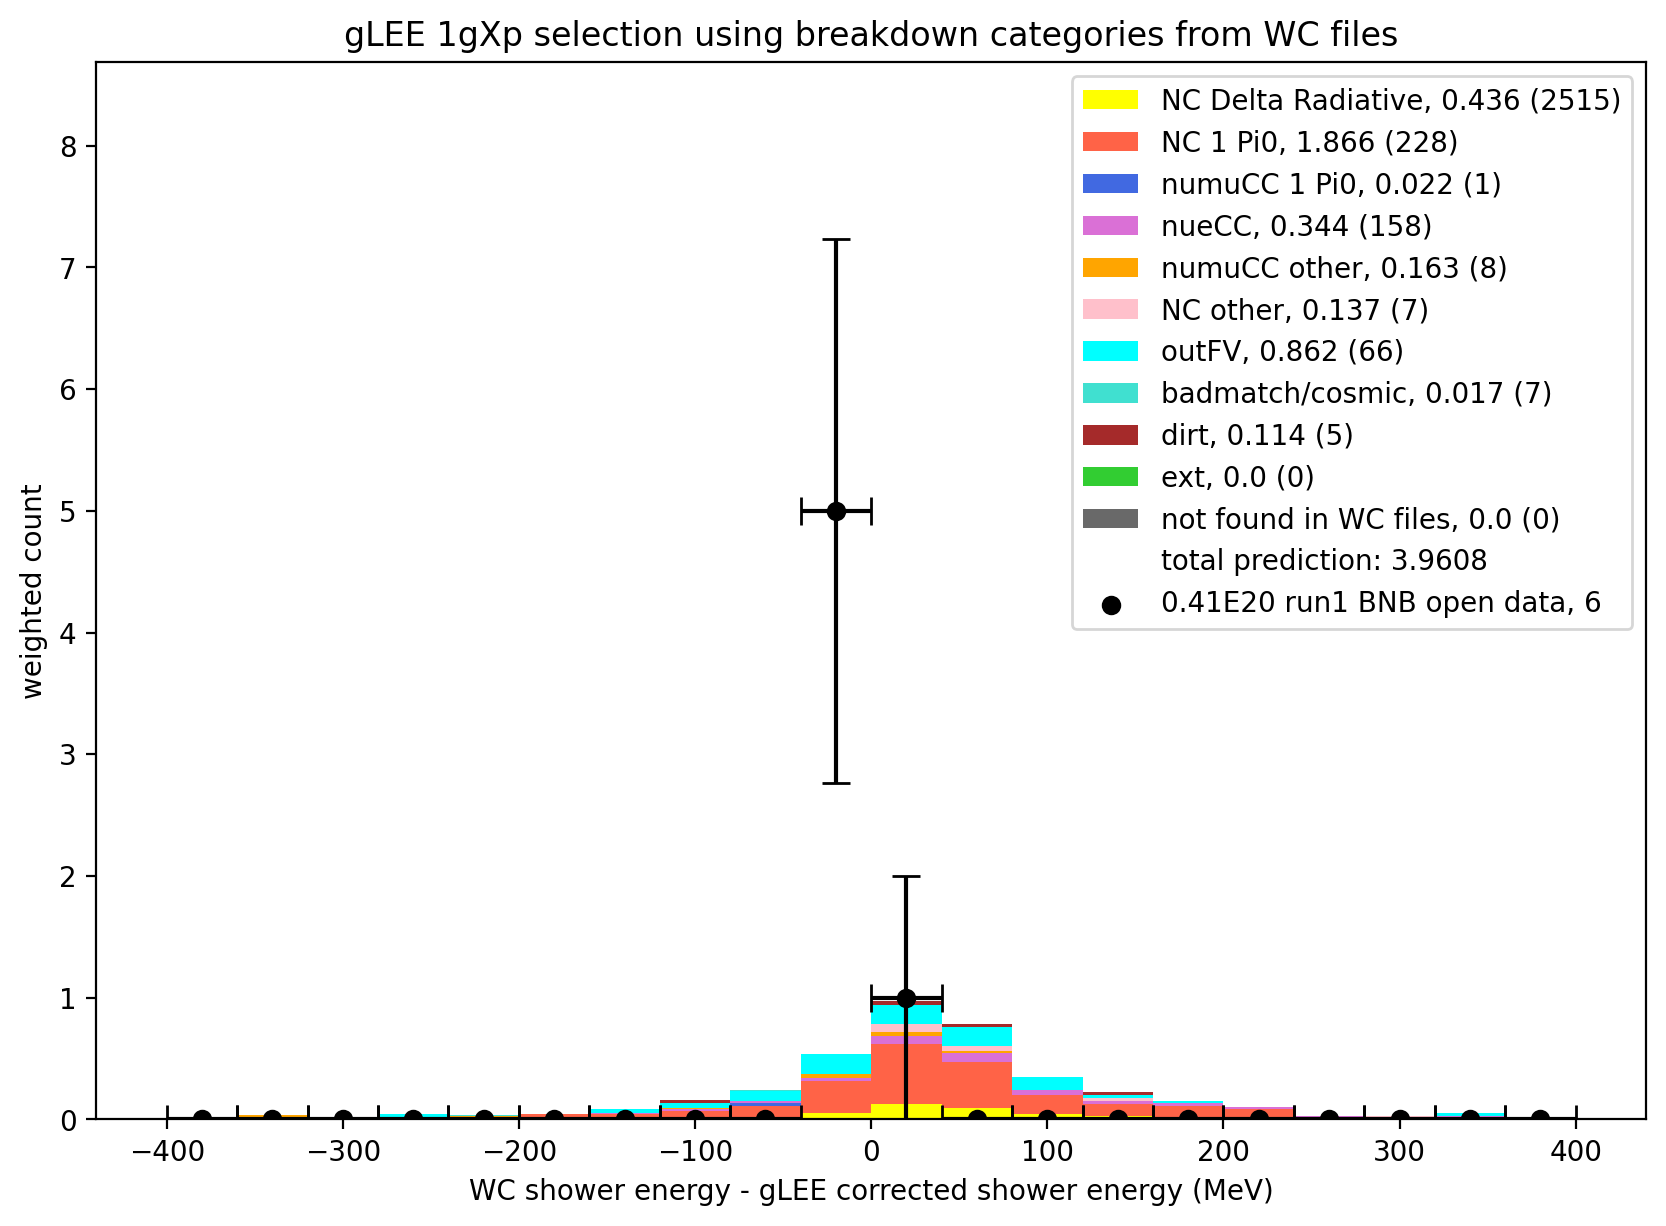

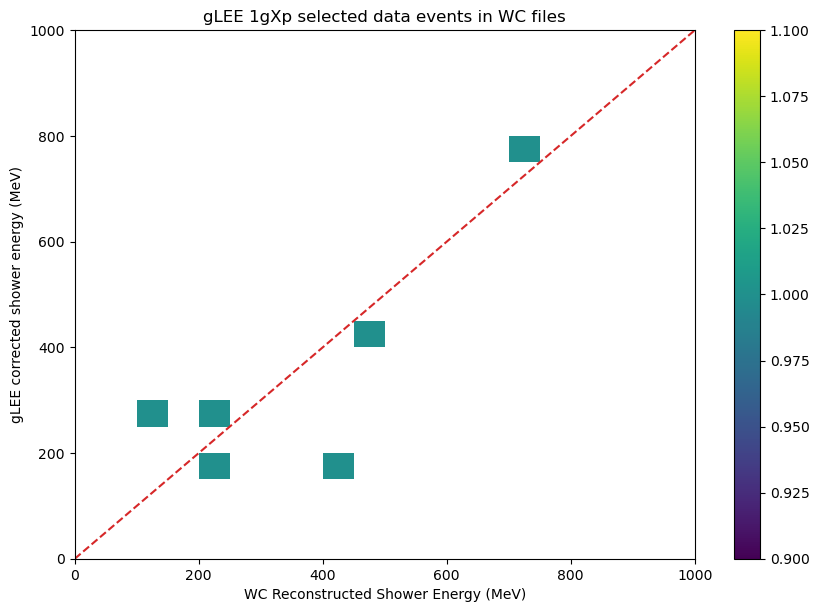

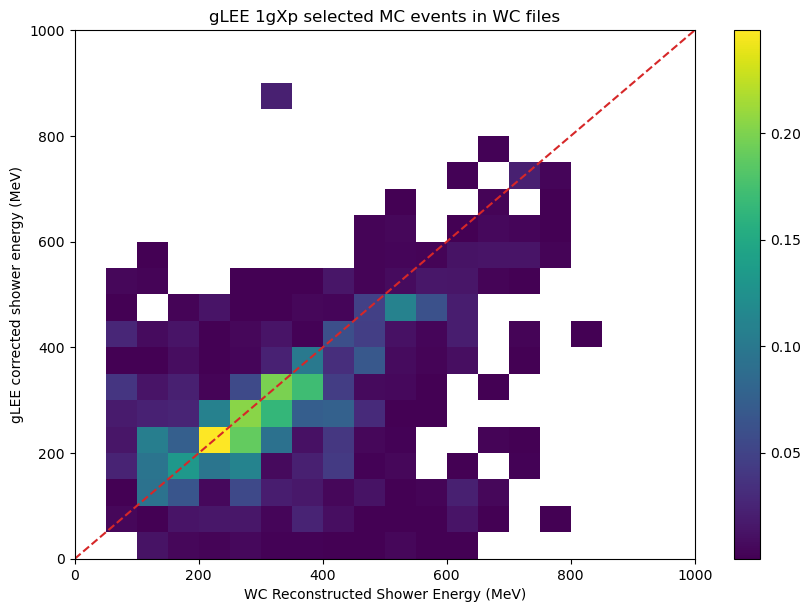

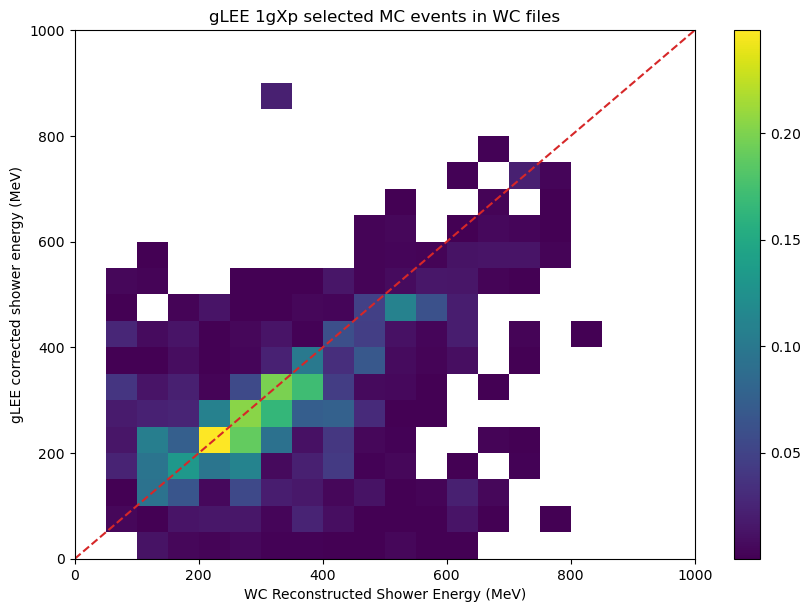

In [15]:
for breakdown_num in [0, 1]:
    categories = [gLEE_categories, wc_categories][breakdown_num]
    queries = [gLEE_queries, wc_queries][breakdown_num]
    colors = [gLEE_colors, wc_colors][breakdown_num]
    
    # only including events in the gLEE files and where WC reconstructs a shower with positive energy
    gLEE_sel_selected_df = merged_gLEE_WC_comparison_df.query("reco_shower_energy_plane2 == reco_shower_energy_plane2 and reco_showerKE > 0")
    
    print(gLEE_sel_selected_df.shape[0])
    
    selected_e_categories = []
    selected_w_categories = []

    for q in queries:
        selected_e_categories.append(gLEE_sel_selected_df.query(f"{q}")["reco_showerKE"].to_numpy() - gLEE_sel_selected_df.query(f"{q}")["reco_shower_energy_plane2_corrected"].to_numpy())
        selected_w_categories.append(gLEE_sel_selected_df.query(f"{q}")["simple_pot_weight"].to_numpy())
    
    bin_edges = np.linspace(-400., 400., 21)

    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2. for i in range(len(bin_edges) - 1)]
    num_bins = len(bin_edges) - 1

    hist_, bin_edges_ = np.histogram(gLEE_sel_selected_df.query("data_or_pred == 'data'")[x_variable].to_numpy(), bins=1, range=(-1e6, 1e6))
            
    data_total = hist_[0]

    hist_, bin_edges_ = np.histogram(gLEE_sel_selected_df.query("data_or_pred == 'data'")[x_variable].to_numpy(), bins=bin_edges)

    data_points = hist_
    data_xerr = (bin_edges[1] - bin_edges[0]) / 2.
    data_yerr = [np.sqrt(x) for x in data_points]

    plt.clf()
    plt.figure(dpi=200, figsize=(10,7))

    total_counts = []
    for i in range(len(selected_e_categories)):
        hist_, bin_edges_ = np.histogram(selected_e_categories[i], bins=1, range=(-1e6, 1e6), weights=selected_w_categories[i])
        total_counts.append(hist_[0])
    legend_strings = [categories[i] + ", " + str(np.round(total_counts[i], 3)) + " (" + str(len(selected_e_categories[i])) + ")" for i in range(len(categories))]

    plt.plot([], [], " ", label="total prediction: " + str(np.round(np.sum(total_counts), 4)))

    plt.hist(selected_e_categories, bins=bin_edges, weights=selected_w_categories, color=colors, label=legend_strings, stacked=True)

    total_pred_by_bin = n_[-1]
    
    plt.errorbar(bin_centers, data_points, yerr=data_yerr, xerr=data_xerr, fmt="none", capsize=5, c="black", zorder=10)
    plt.scatter(bin_centers, data_points, label=f"0.41E20 run1 BNB open data, {data_total}", color="black", zorder=10)

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [i + 1 for i in range(len(queries))] + [0, len(queries) + 1]
    #order = [1,2,3,4,5,6,7,8,9,10,11,0,12]
    L = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    L.set_zorder(20)

    plt.xlabel("WC shower energy - gLEE corrected shower energy (MeV)")
    # (reco_showerKE - (1.21 * reco_shower_energy_plane2 + 9.88))

    plt.ylabel("weighted count")
    plt.title(f"gLEE 1gXp selection using breakdown categories from {['gLEE', 'WC'][breakdown_num]} files")
    
    plt.ylim(0, 1.2 * np.max(np.concatenate((total_pred_by_bin, data_points + data_yerr))))

    plt.savefig(f"gLEE_comparison_plots/reco_shower_energy_diff_{['gLEE', 'WC'][breakdown_num]}_breakdown.png")
    
    
x_bin_edges = np.linspace(0., 1000., 21)
y_bin_edges = np.linspace(0., 1000., 21)
bins = (x_bin_edges, y_bin_edges)

plt.figure(dpi=100, figsize=(10,7))
ax = plt.gca()
plt.hist2d(gLEE_sel_selected_df.query("data_or_pred == 'data'")["reco_showerKE"].to_numpy(), 
           gLEE_sel_selected_df.query("data_or_pred == 'data'")["reco_shower_energy_plane2_corrected"].to_numpy(), 
           weights=gLEE_sel_selected_df.query("data_or_pred == 'data'")["simple_pot_weight"].to_numpy(),
           bins=bins, cmin = 1e-10)
plt.xlabel("WC Reconstructed Shower Energy (MeV)")
plt.ylabel("gLEE corrected shower energy (MeV)")
plt.title("gLEE 1gXp selected data events in WC files")
plt.colorbar()
plt.plot([0, x_bin_edges[-1]], [0, y_bin_edges[-1]], ls="--", c="tab:red")
#plt.title("1g0p0pi Selection Prediction")
#ax.xaxis.set_major_locator(MultipleLocator(500))
#ax.xaxis.set_major_formatter('{x:.0f}')
#ax.xaxis.set_minor_locator(MultipleLocator(50))
#ax.yaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#plt.grid()
#plt.clim(10**-4, 10**3)
plt.savefig(f"gLEE_comparison_plots/2d_shower_energy_comparison_data.png")

plt.figure(dpi=100, figsize=(10,7))
ax = plt.gca()
plt.hist2d(gLEE_sel_selected_df.query("data_or_pred == 'pred'")["reco_showerKE"].to_numpy(), 
           gLEE_sel_selected_df.query("data_or_pred == 'pred'")["reco_shower_energy_plane2_corrected"].to_numpy(), 
           weights=gLEE_sel_selected_df.query("data_or_pred == 'pred'")["simple_pot_weight"].to_numpy(),
           bins=bins, cmin = 1e-10)
plt.xlabel("WC Reconstructed Shower Energy (MeV)")
plt.ylabel("gLEE corrected shower energy (MeV)")
plt.title("gLEE 1gXp selected MC events in WC files")
plt.colorbar()

plt.plot([0, x_bin_edges[-1]], [0, y_bin_edges[-1]], ls="--", c="tab:red")

#plt.title("1g0p0pi Selection Prediction")
#ax.xaxis.set_major_locator(MultipleLocator(500))
#ax.xaxis.set_major_formatter('{x:.0f}')
#ax.xaxis.set_minor_locator(MultipleLocator(50))
#ax.yaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#plt.grid()
#plt.clim(10**-4, 10**3)
plt.savefig(f"gLEE_comparison_plots/2d_shower_energy_comparison_pred.png")

plt.figure(dpi=100, figsize=(10,7))
ax = plt.gca()
plt.hist2d(gLEE_sel_selected_df.query("data_or_pred == 'pred'")["reco_showerKE"].to_numpy(), 
           gLEE_sel_selected_df.query("data_or_pred == 'pred'")["reco_shower_energy_plane2_corrected"].to_numpy(), 
           weights=gLEE_sel_selected_df.query("data_or_pred == 'pred'")["simple_pot_weight"].to_numpy(),
           bins=bins, cmin = 1e-10)
plt.xlabel("WC Reconstructed Shower Energy (MeV)")
plt.ylabel("gLEE corrected shower energy (MeV)")
plt.title("gLEE 1gXp selected MC events in WC files")
plt.colorbar()

plt.plot([0, x_bin_edges[-1]], [0, y_bin_edges[-1]], ls="--", c="tab:red")

#plt.title("1g0p0pi Selection Prediction")
#ax.xaxis.set_major_locator(MultipleLocator(500))
#ax.xaxis.set_major_formatter('{x:.0f}')
#ax.xaxis.set_minor_locator(MultipleLocator(50))
#ax.yaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#plt.grid()
#plt.clim(10**-4, 10**3)
plt.savefig(f"gLEE_comparison_plots/2d_shower_energy_comparison_pred.png")


In [12]:
gLEE_sel_selected_df.query("data_or_pred == 'data'")

,data_or_pred,run,subrun,event,category,WC_file,match_isFC,kine_reco_Enu,reco_showerKE,nc_delta_score,...,reco_shower_energy_plane0,reco_shower_energy_plane1,reco_shower_energy_plane2,reco_vertex_x,reco_vertex_y,reco_vertex_z,simple_pot_weight,gLEE_file,gLEE_selection,reco_shower_energy_plane2_corrected
1471939,data,5783,129,6464,data,open_data_run1,True,522.370361,113.214455,-4.413878,...,217.081220,217.081220,217.081220,100.292343,-54.400337,648.154968,1.0,data,1g0p,272.548276
3558565,data,5506,30,1506,data,open_data_run1,True,493.756470,464.838013,5.624367,...,350.072526,350.072526,350.072526,159.181702,-43.122734,671.978577,1.0,data,1g0p,433.467757
4883710,data,5904,22,1128,data,open_data_run1,True,777.986694,733.863708,-0.208355,...,641.165635,641.165635,641.165635,85.821220,-37.485920,673.314392,1.0,data,1g0p,785.690418
5267301,data,5187,188,9430,data,open_data_run1,True,270.433777,205.385468,-1.764994,...,118.445094,118.445094,118.445094,145.823700,-99.590530,295.475037,1.0,data,1g0p,153.198563
5872698,data,5762,114,5732,data,open_data_run1,True,776.491272,424.827087,-6.114510,...,143.989547,143.989547,143.989547,113.383087,60.917236,541.001648,1.0,data,1g1p,184.107352
7871927,data,5203,89,4499,data,open_data_run1,True,470.343384,223.639297,-3.658758,...,228.842836,228.842836,228.842836,210.058868,-79.360077,384.346039,1.0,data,1g0p,286.779831


In [13]:
# construct my best guess for what the glee_reco_shower_KE variable is (converted plane 2, if it doesn't exist then converted plane 1?)

# make a glee_reco_shower_KE plot, with WC breakdown categories, including not_passing_WC_preselection breakdown category (meaning not generic, 
# from an unprocessed file, excluded for training, or partially contained). Could further break that down if necessary. 
# Include data points (should match what gLEE already showed)

# make a NC_Delta_bdt_score plot using gLEE weights, with WC breakdown categories. Also plot data points here. 
# The completeness of this plot is judged by the previous plot.

# plot difference in reco shower KE for each channel.

# repeat for 0p

# 0p/Np separation should fit into these plots somehow? Maybe just list what fraction of MC and data events are miscategorized in each case
# (I expect pretty good agreement)

In [14]:
# other category is: not found in WC files means excluded for training, excluded in favor of events from a dedicated file, or simply from a file that WC isn't using at all